# cluster the cryo type A scans (1,2,3) and the cryo type B scans (4,5)
May 3, 2022

In [1]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import tools.roifinder.roif_config    
from tools.roifinder.roif_config import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import rc
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import seaborn as sns

import tools.roifinder.xrf_roif_internals
from tools.roifinder.xrf_roif_internals import *
import tools.roifinder.xrfm_batches
from tools.roifinder.xrfm_batches import *
import tools.roifinder.fuzzy_kmeans_engine
from tools.roifinder.fuzzy_kmeans_engine import _format_soft_km_axes, soft_clustering_weights

%matplotlib inline

# define parameters

In [2]:
BASE_PATCH_WIDTH=32
selected_elm_maps=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','Total_Fluorescence_Yield']
noise_type='none'
base_file_path = '../xrfdata/'



coarse_scan_names = ['scan1.mda.h5', 
                    'scan2.mda.h5',
                    'scan3.mda.h5',
                    'scan4.mda.h5',
                    'scan5.mda.h5']

# 'bnp_fly0050.mda.h5',
#                     'bnp_fly0051.mda.h5']



hdf5_string_list=['MAPS','MAPS','MAPS','MAPS','MAPS']
norm_ch_list=['US_IC','US_IC','US_IC','US_IC','US_IC']
selected_elm_maps_list=[selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps,selected_elm_maps]
noise_type_list = [noise_type,noise_type,noise_type,noise_type,noise_type]
# bin_conv_elm_list=['P', 'P', 'P', 'P', 'Zn']
bin_conv_elm_list=['KPSCa', 'KPSCa', 'KPSCa', 'KPSCa', 'KPSCa']
apply_gaussian_list=[False, False, False, False,False]
value_offset_list = [1e-12,1e-12,1e-12,1e-12,1e-12]


# assemble coarse scans

In [3]:
coarse_scans = XRFM_batch(base_file_path,
                  coarse_scan_names,
                 hdf5_string_list,
                 norm_ch_list,
                 selected_elm_maps_list,
                 noise_type_list,
                 bin_conv_elm_list,
                 value_offset_list,
                apply_gaussian_list,
                 BASE_PATCH_WIDTH,
                 print_pv=False,  
                 verbosity=False)

print('Bounding box width and height (pixels):' , BASE_PATCH_WIDTH)
print('Total extracted cells, features:', coarse_scans.X.shape)
print('Total extracted cell, cell size:', coarse_scans.X_bin.shape)


XRF ../xrfdata/scan1.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(41, 14)
XRF ../xrfdata/scan2.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(36, 14)
XRF ../xrfdata/scan3.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(17, 14)
XRF ../xrfdata/scan4.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(19, 14)
XRF ../xrfdata/scan5.mda.h5
['Cu', 'Zn', 'Ca', 'K', 'P', 'S', 'Fe', 'Ni', 'Total_Fluorescence_Yield']
(11, 14)
Bounding box width and height (pixels): 32
Total extracted cells, features: (124, 14)
Total extracted cell, cell size: (124, 32, 32)


/data02/AZC/ROI-Finder/flx_workflows/../tools/roifinder/xrf_roif_internals.py:118: RuntimeWarning: divide by zero encountered in true_divide
  xrfdata[e].append(xrf[chidx]/norm)
/data02/AZC/ROI-Finder/flx_workflows/../tools/roifinder/xrf_roif_internals.py:118: RuntimeWarning: invalid value encountered in true_divide
  xrfdata[e].append(xrf[chidx]/norm)


(321, 321)
(321, 321)
(149, 321)
(321, 321)
(118, 321)


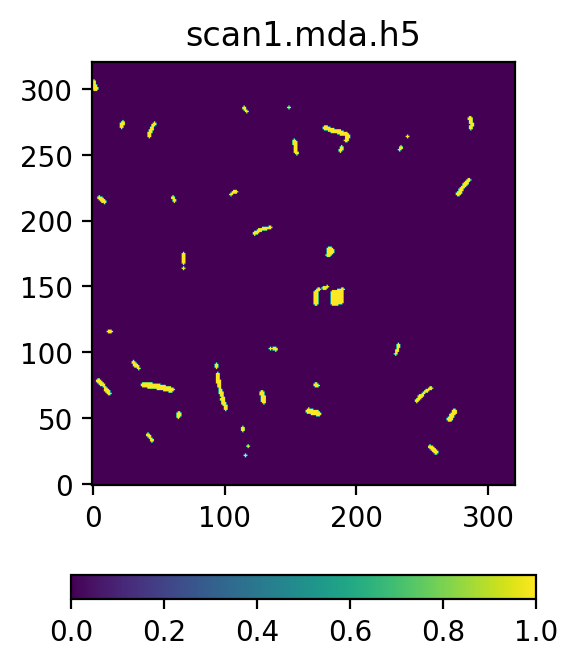

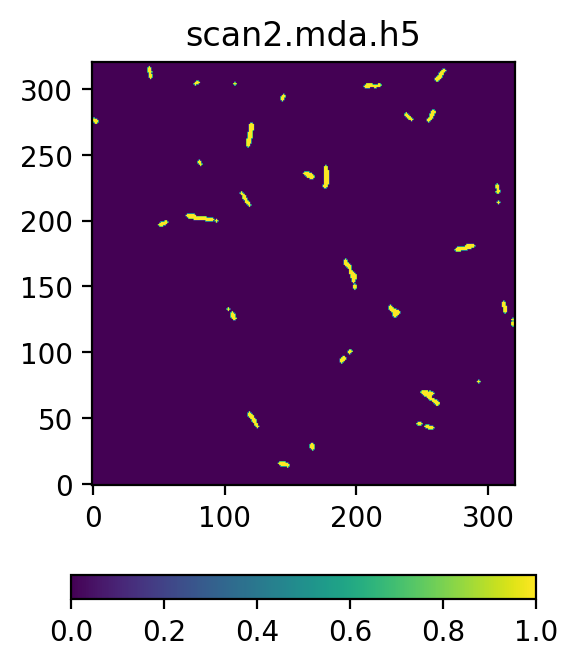

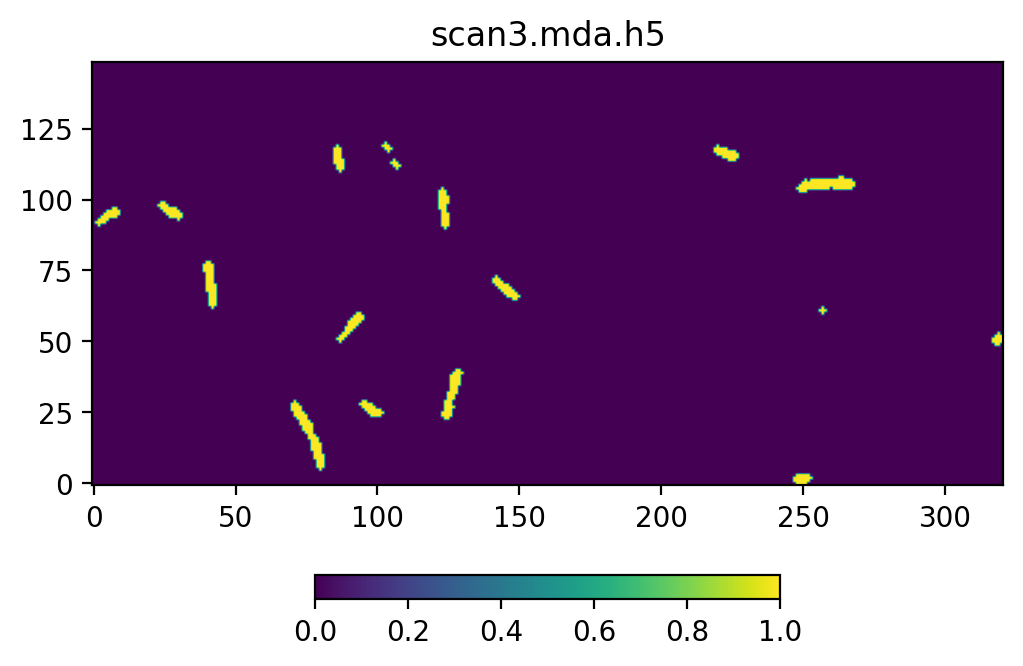

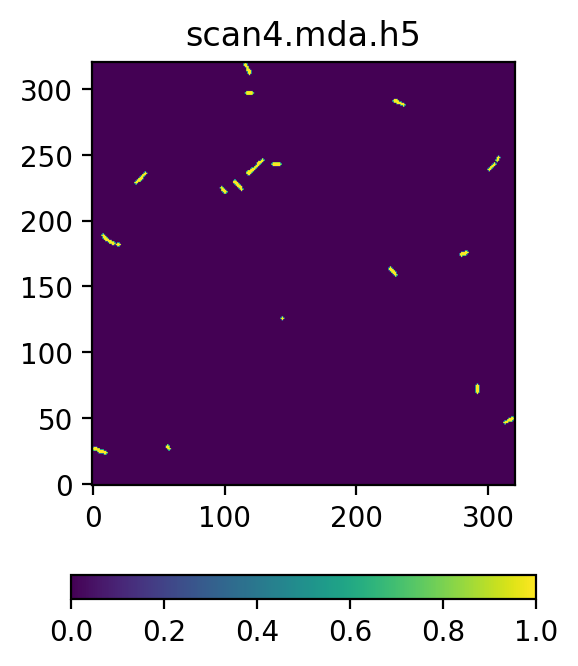

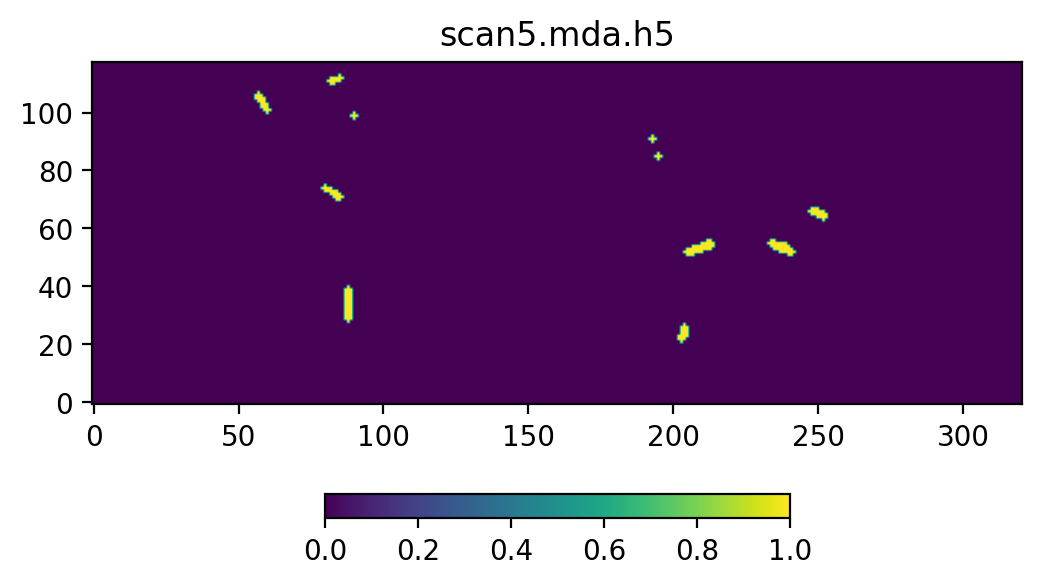

In [4]:
coarse_scans.plot_coarse_binary_images()

# construct dataframe with all the extracted information from defined features
inside the beamtime_XRF_image_extract_cell_method

In [5]:
principalDf = pd.DataFrame(
             columns = ['Pixel_count', 'area'])


principalDf['area'] = coarse_scans.X[:,0]
principalDf['eccentricity'] = coarse_scans.X[:,1]
principalDf['equivalent_diameter'] = coarse_scans.X[:,2]
principalDf['major_axis_length'] = coarse_scans.X[:,3]
principalDf['minor_axis_length'] = coarse_scans.X[:,4]
principalDf['perimeter'] = coarse_scans.X[:,5]
principalDf['K'] = coarse_scans.X[:,6]
principalDf['P'] = coarse_scans.X[:,7]
principalDf['Ca'] = coarse_scans.X[:,8]
principalDf['Zn'] = coarse_scans.X[:,9]
principalDf['Fe'] = coarse_scans.X[:,10]
principalDf['Cu'] = coarse_scans.X[:,11]
principalDf['BFY'] = coarse_scans.X[:,12]
principalDf['Pixel_count'] = coarse_scans.X[:,13].astype(int)   #Pixel_count column must exist

#add res and origins to dataframe here
#convert from list
principalDf['x_res'] = coarse_scans.X_x_res
principalDf['y_res'] = coarse_scans.X_y_res
principalDf['avg_res'] = coarse_scans.X_avg_res
principalDf['x_origin'] = coarse_scans.X_x_origin
principalDf['y_origin'] = coarse_scans.X_y_origin
principalDf['x_motor'] = coarse_scans.X_x_motor
principalDf['y_motor'] = coarse_scans.X_y_motor
principalDf['xrf_file']=coarse_scans.X_xrf_track_files




#assign scan names in dataframe
number_of_cells = principalDf['xrf_file'].to_numpy().shape[0]
coarse_scan_name=[]
for idx in range(number_of_cells):

    coarse_scan_name.append(os.path.split(principalDf['xrf_file'].to_numpy()[idx])[1])
principalDf['scan_name'] =  np.array(coarse_scan_name)  


display(principalDf)

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,xrf_file,scan_name
0,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000042,0.000038,0.000047,...,0.007212,0.25,0.256287,0.253143,110.674377,-661.065186,139.674377,-655.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5
1,31,1.9375,0.926864,1.570637,2.566840,0.963588,5.242641,0.000042,0.000085,0.000074,...,0.007246,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5
2,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000036,0.000046,0.000051,...,0.007115,0.25,0.256287,0.253143,110.674377,-661.065186,140.174377,-653.815186,../xrfdata/scan1.mda.h5,scan1.mda.h5
3,21,1.3125,0.945323,1.292721,2.313760,0.754599,3.828427,0.000069,0.000055,0.000065,...,0.007196,0.25,0.256287,0.253143,110.674377,-661.065186,121.424377,-652.315186,../xrfdata/scan1.mda.h5,scan1.mda.h5
4,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000046,0.000057,0.000034,...,0.007210,0.25,0.256287,0.253143,110.674377,-661.065186,139.174377,-650.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000017,0.000139,0.000079,...,0.002593,0.25,0.245728,0.247864,-73.469749,-1059.976318,-24.719749,-1038.726318,../xrfdata/scan5.mda.h5,scan5.mda.h5
120,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000024,0.000138,0.000091,...,0.002823,0.25,0.245728,0.247864,-73.469749,-1059.976318,-25.219749,-1037.226318,../xrfdata/scan5.mda.h5,scan5.mda.h5
121,5,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000009,0.000054,0.000065,...,0.002072,0.25,0.245728,0.247864,-73.469749,-1059.976318,-50.969749,-1035.226318,../xrfdata/scan5.mda.h5,scan5.mda.h5
122,21,1.3125,0.941908,1.292721,2.248000,0.755036,4.181981,0.000017,0.000119,0.000056,...,0.001975,0.25,0.245728,0.247864,-73.469749,-1059.976318,-58.969749,-1034.226318,../xrfdata/scan5.mda.h5,scan5.mda.h5


# remove extracted cells that contain less than certain amount of pixels

In [6]:
secondaryDf=remove_artifacts(principalDf, remove_count = 8)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(secondaryDf)

# secondaryDf.head()

/data02/AZC/ROI-Finder/flx_workflows/../tools/roifinder/xrf_roif_internals.py:877: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['original index'] = secondaryDf.index.to_numpy()


,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,Zn,Fe,Cu,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,xrf_file,scan_name,original index
0,31,1.9375,0.926864,1.570637,2.566840,0.963588,5.242641,0.000042,0.000085,0.000074,0.000071,0.000048,0.000072,0.007246,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5,1
1,21,1.3125,0.945323,1.292721,2.313760,0.754599,3.828427,0.000069,0.000055,0.000065,0.000051,0.000035,0.000046,0.007196,0.25,0.256287,0.253143,110.674377,-661.065186,121.424377,-652.315186,../xrfdata/scan1.mda.h5,scan1.mda.h5,3
2,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000046,0.000057,0.000034,0.000053,0.000040,0.000037,0.007210,0.25,0.256287,0.253143,110.674377,-661.065186,139.174377,-650.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5,4
3,42,2.6250,0.926738,1.828183,3.026790,1.137187,6.389087,0.000054,0.000088,0.000078,0.000055,0.000042,0.000059,0.007298,0.25,0.256287,0.253143,110.674377,-661.065186,178.674377,-648.065186,../xrfdata/scan1.mda.h5,scan1.mda.h5,5
4,18,1.1250,0.722659,1.196827,1.423347,0.983824,3.267767,0.000042,0.000064,0.000100,0.000070,0.000044,0.000052,0.007146,0.25,0.256287,0.253143,110.674377,-661.065186,126.924377,-648.065186,../xrfdata/scan1.mda.h5,scan1.mda.h5,6
5,49,3.0625,0.925859,1.974664,3.245418,1.226342,7.035534,0.000044,0.000089,0.000127,0.000077,0.000041,0.000051,0.007242,0.25,0.256287,0.253143,110.674377,-661.065186,152.424377,-647.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5,7
6,95,5.9375,0.993093,2.749520,8.450952,0.991554,15.906854,0.000055,0.000079,0.000064,0.000049,0.000051,0.000058,0.007374,0.25,0.256287,0.253143,110.674377,-661.065186,134.924377,-643.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5,8
7,38,2.3750,0.927087,1.738949,2.844144,1.066118,5.974874,0.000055,0.000073,0.000113,0.000045,0.000046,0.000046,0.007229,0.25,0.256287,0.253143,110.674377,-661.065186,142.924377,-644.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5,9
8,47,2.9375,0.984730,1.933944,4.921048,0.856704,7.303301,0.000050,0.000099,0.000051,0.000058,0.000039,0.000058,0.007299,0.25,0.256287,0.253143,110.674377,-661.065186,173.174377,-644.065186,../xrfdata/scan1.mda.h5,scan1.mda.h5,10
9,50,3.1250,0.977717,1.994711,4.549151,0.955001,8.010408,0.000050,0.000064,0.000114,0.000078,0.000044,0.000051,0.007258,0.25,0.256287,0.253143,110.674377,-661.065186,112.674377,-642.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5,11


# view the location of a cell on main XRF image
must be in matplotlib inline mode

In [7]:
coarse_scans.ROI_viewer(selected_elm_channel = 'P', linethresh_val=0.00001)


interactive(children=(IntSlider(value=61, description='idx', max=123), Output()), _dom_classes=('widget-intera…

# view all extracted cells if all elements are analyzed.

In [8]:

linethresh_val=0.00001
# resolution=DEFAULT_RESOLUTION_CELL

%matplotlib inline

def viewer(idx):    
    
    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    
    im1 = ax1.imshow(coarse_scans.X_bin[idx], interpolation='none')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*coarse_scans.X_x_res[idx], "m", color='white', length_fraction=0.10, box_alpha=0.10)
    ax1.add_artist(scalebar_master)
    ax1.invert_yaxis()
    
    

    ax2 = fig.add_subplot(522)
    ax2.set_title('Cu')
    ax2.invert_yaxis()
    im2 = ax2.imshow(coarse_scans.X_Cu[idx], interpolation='none')
#     im2 = ax2.imshow(X_Cu[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');
    ax2.invert_yaxis()


    ax3 = fig.add_subplot(523)
    ax3.set_title('Zn')
    ax3.invert_yaxis()
    im3 = ax3.imshow(coarse_scans.X_Zn[idx], interpolation='none')
#     im3 = ax3.imshow(X_Zn[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical');
    ax3.invert_yaxis()

    ax4 = fig.add_subplot(524)
    ax4.set_title('Ca')
    ax4.invert_yaxis()
    im4 = ax4.imshow(coarse_scans.X_Ca[idx], interpolation='none', vmax=0.000035)
#     im4 = ax4.imshow(X_Ca[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val) )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical');
    ax4.invert_yaxis()


    ax5 = fig.add_subplot(525)
    ax5.set_title('K')
    ax5.invert_yaxis()
    im5 = ax5.imshow(coarse_scans.X_K[idx], interpolation='none')
#     im5 = ax5.imshow(X_K[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical');
    ax5.invert_yaxis()

    ax6 = fig.add_subplot(526)
    ax6.set_title('P')
    ax6.invert_yaxis()
    im6 = ax6.imshow(coarse_scans.X_P[idx], interpolation='none')
#     im6 = ax6.imshow(X_P[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical');
    ax6.invert_yaxis()

    ax7 = fig.add_subplot(527)
    ax7.set_title('S')
    ax7.invert_yaxis()
    im7 = ax7.imshow(coarse_scans.X_S[idx], interpolation='none', vmax=0.000122)
#     im7 = ax7.imshow(X_S[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax7)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im7, cax=cax, orientation='vertical');
    ax7.invert_yaxis()

    ax8 = fig.add_subplot(528)
    ax8.set_title('Ni')
    ax8.invert_yaxis()
    im8 = ax8.imshow(coarse_scans.X_Ni[idx], interpolation='none')
#     im8 = ax8.imshow(X_Ni[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax8)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im8, cax=cax, orientation='vertical');
    ax8.invert_yaxis()

    ax9 = fig.add_subplot(529)
    ax9.set_title('Fe')
    ax9.invert_yaxis()
    im9 = ax9.imshow(coarse_scans.X_Fe[idx], interpolation='none')
#     im9 = ax9.imshow(X_Fe[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax9)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im9, cax=cax, orientation='vertical');
    ax9.invert_yaxis()

    ax10 = fig.add_subplot(5,2,10)
    ax10.set_title('TFY')
    ax10.invert_yaxis()
    im10 = ax10.imshow(coarse_scans.X_TFY[idx], interpolation='none')
#     im10 = ax10.imshow(X_TFY[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = 500*linethresh_val))
    divider = make_axes_locatable(ax10)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im10, cax=cax, orientation='vertical');
    ax10.invert_yaxis()
    
    print('Avg. Cu:',np.average(coarse_scans.X_Cu[idx]))
    print('Avg. Zn:',np.average(coarse_scans.X_Zn[idx]))
    print('Avg. Ca:',np.average(coarse_scans.X_Ca[idx]))
    print('Avg. K:',np.average(coarse_scans.X_K[idx]))
    print('Avg. P:',np.average(coarse_scans.X_P[idx]))
    print('Avg. S:',np.average(coarse_scans.X_S[idx]))
    print('Avg. Fe:',np.average(coarse_scans.X_Fe[idx]))
    print('Avg. Ni:',np.average(coarse_scans.X_Ni[idx]))
    print('Avg. TFY:',np.average(coarse_scans.X_TFY[idx]))
    
    print('Max. Cu:',np.max(coarse_scans.X_Cu[idx]))
    print('Max. Zn:',np.max(coarse_scans.X_Zn[idx]))
    print('Max. Ca:',np.max(coarse_scans.X_Ca[idx]))
    print('Max. K:',np.max(coarse_scans.X_K[idx]))
    print('Max. P:',np.max(coarse_scans.X_P[idx]))
    print('Max. S:',np.max(coarse_scans.X_S[idx]))
    print('Max. Fe:',np.max(coarse_scans.X_Fe[idx]))
    print('Max. Ni:',np.max(coarse_scans.X_Ni[idx]))
    print('Max. TFY:',np.max(coarse_scans.X_TFY[idx]))
    

    
    

interactive_plot = interactive(viewer, idx=(0, len(coarse_scans.X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot



interactive(children=(IntSlider(value=61, description='idx', max=123), Output()), _dom_classes=('widget-intera…

# Construct the features for PCA

In [9]:
# mod_X = np.asarray([
#     secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
#     secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
#     secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe'],
#     secondaryDf['Cu'],secondaryDf['BFY']
#                ]).T

# mod_X = np.asarray([
#     secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
#     secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
#     secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe']
#                ]).T


mod_X = np.asarray([
    secondaryDf['area'],secondaryDf['eccentricity'],
    secondaryDf['K'],secondaryDf['P'],secondaryDf['Ca'],secondaryDf['Zn'],secondaryDf['Fe']
               ]).T

print('Cells, features', mod_X.shape)

Cells, features (106, 7)


# perform PCA

PC = f('area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ca','Zn',
         'Fe')
         

Cells, PCs (106, 2)
singular_values_: [14.95508058 12.83315463]
explained_variance: [2.13004224 1.56847484]
components: [[ 0.28432613  0.41563912 -0.21150339  0.44361483  0.55675397  0.44079471
   0.02449505]
 [ 0.3784722   0.18879809  0.63311783 -0.42938884  0.10842451  0.15190484
   0.44840847]]


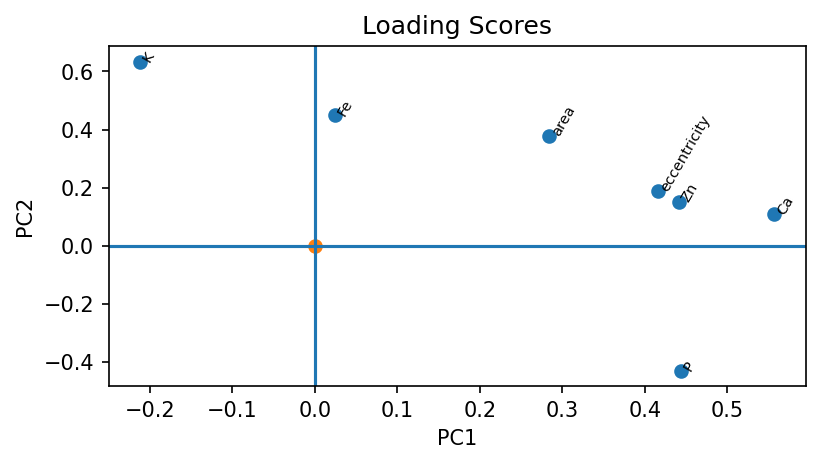

<Figure size 432x288 with 0 Axes>

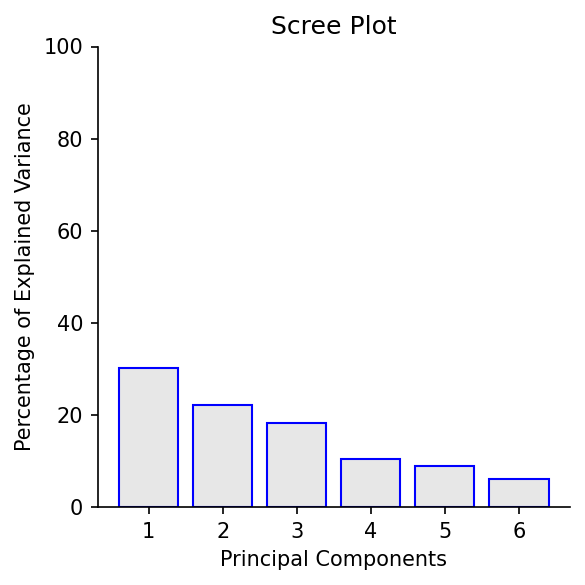

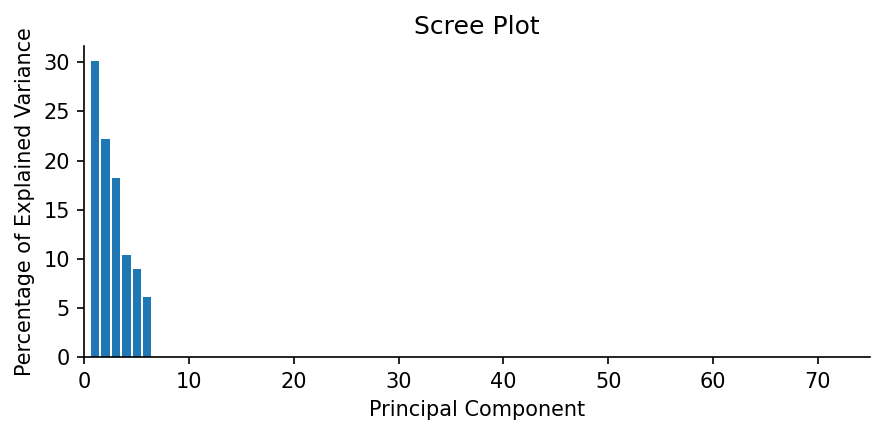

/tmp/ipykernel_33714/4082877442.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['PC1']=principalComponents[:,0]
/tmp/ipykernel_33714/4082877442.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['PC2']=principalComponents[:,1]


IndexError: index 2 is out of bounds for axis 1 with size 2

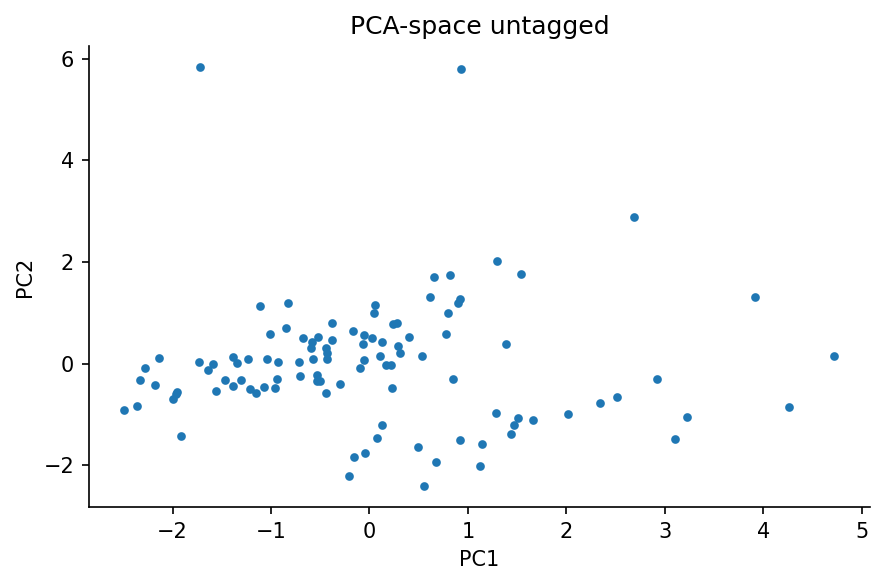

In [10]:
%matplotlib inline

# feature_names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
#         'K','P','Ca','Zn',
#          'Fe']

feature_names = ['area','eccentricity','K','P','Ca','Zn','Fe']


principalComponents, loading_scores = XRF_PCA(mod_X, feature_names, high_comp=6, n_components=2, 
                                              annot_txt_size=7, dpi =150, marker_size=3,save_plots=True)

#assign PC values to dataframe
secondaryDf['PC1']=principalComponents[:,0]
secondaryDf['PC2']=principalComponents[:,1]
secondaryDf['PC3']=principalComponents[:,2]



In [ ]:
# feature_list = ["area", "eccentricity","K","P"]
feature_list = ["area", "eccentricity", "K"]
# feature_list = ["K","P"]
# PC_names=["PC1", "PC2","PC3"]
PC_names=["PC1", "PC2"]

    
view_PC_feature_relation(secondaryDf,PC_names, feature_list, hue = 'scan_name',save_plots=True )

In [ ]:
secondaryDf.head()

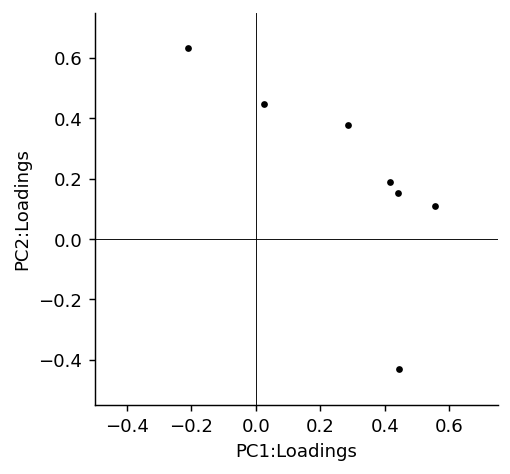

In [11]:
annot_txt_size=8

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.figure(figsize=(4,4),dpi=130)
plt.scatter(loading_scores[0],loading_scores[1],color='black',s=7.5) #, tick_label=PClabels
# plt.title('Loading Scores')
plt.xlabel('PC1:Loadings')
plt.ylabel('PC2:Loadings')
plt.axhline(color='black', linewidth = 0.5)
plt.axvline(color='black', linewidth = 0.5)
plt.xlim([-0.50,0.75])
plt.ylim([-0.55,0.75])

# figure_scale_factor=2
# plt.xlim([fig.data[0]['x'].min()/figure_scale_factor,fig.data[0]['x'].max()/figure_scale_factor])
# plt.ylim([fig.data[0]['y'].min()/figure_scale_factor,fig.data[0]['y'].max()/figure_scale_factor])


# plt.arrow(x=0, y=0, dx=loading_scores[0][0], dy=loading_scores[1][0], width=.005) 
 
arrow_scale_factor=0.85
# for i, txt in enumerate(feature_names):
# #     plt.arrow(x=0, y=0, dx=arrow_scale_factor*loading_scores[0][i], dy=arrow_scale_factor*loading_scores[1][i], 
# #               width=.005,color ='black') 
#     plt.annotate(str('  ')+txt, (loading_scores[0][i], loading_scores[1][i]), rotation=0, size=annot_txt_size)
    
# plt.axis()
plt.savefig('../figures/PC_space_loading_scores.jpg')

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Length true list:  81
Length true list 102 :  0
Length true list 103:  0
Length true list 104:  0
Length true list:  0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/tmp/ipykernel_33714/976815794.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['text_labels'] = text_labels
/tmp/ipykernel_33714/976815794.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['dwell_times'] = dwell_times
/tmp/ipykernel_33714/976815794.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

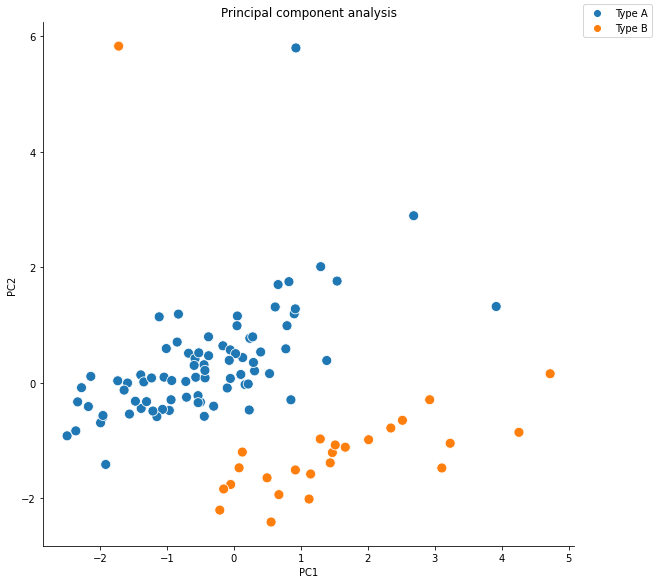

In [12]:
# condition check

labels = [0] * mod_X.shape[0]
dwell_times = [float(100)] * mod_X.shape[0]
print(dwell_times)
text_labels=labels

True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='scan1.mda.h5') | 
    (secondaryDf['scan_name']=='scan2.mda.h5') | 
    (secondaryDf['scan_name']=='scan3.mda.h5')  
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
# print(labels)



True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='scan6.mda.h5') 
   ].index.tolist()    
    
print('Length true list 102 : ', len(True_list) )
for idx in True_list:
    labels[idx]=2 
    dwell_times[idx]=50.0
    
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='scan7.mda.h5') 
   ].index.tolist()    
    
print('Length true list 103: ', len(True_list) )
for idx in True_list:
    labels[idx]=2 
    dwell_times[idx]=25.0
    
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='scan8.mda.h5') 
   ].index.tolist()    
    
print('Length true list 104: ', len(True_list) )
for idx in True_list:
    labels[idx]=2 
    dwell_times[idx]=12.5
    
print('Length true list: ', len(True_list) )
print(labels)

y_dh=np.array(labels).astype(int)    #domain h labels
y=labels

RANGE=mod_X.shape[0]

for idx in range(RANGE):
    if text_labels[idx] ==0:
        text_labels[idx] = 'Type B'
    if text_labels[idx] ==1:
        text_labels[idx] = 'Type A'
    if text_labels[idx] ==2:
        text_labels[idx] = 'Type C'
   
        
secondaryDf['text_labels'] = text_labels
secondaryDf['dwell_times'] = dwell_times
secondaryDf['inv_dwell_times'] = np.reciprocal(np.array(dwell_times))

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')

# plt.savefig('../figures/Noise_Analysis1.jpg')

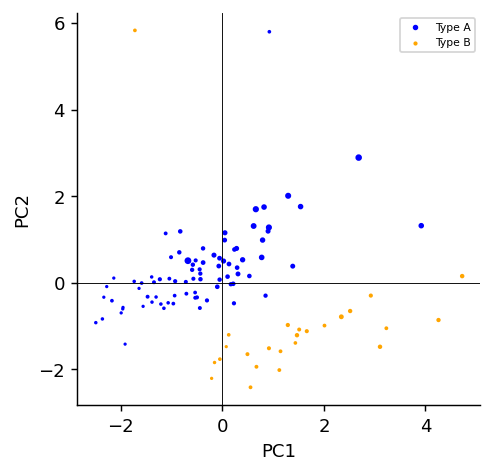

In [13]:
plt.figure(figsize=(4,4),dpi=130)
plt.scatter(secondaryDf[secondaryDf['text_labels']== 'Type A']['PC1'].to_numpy(),
            secondaryDf[secondaryDf['text_labels']== 'Type A']['PC2'].to_numpy(),
            color='blue',s=secondaryDf[secondaryDf['text_labels']== 'Type A']['area'].to_list(), label='Type A')

plt.scatter(secondaryDf[secondaryDf['text_labels']== 'Type B']['PC1'].to_numpy(),
            secondaryDf[secondaryDf['text_labels']== 'Type B']['PC2'].to_numpy(),
            color='orange',s=secondaryDf[secondaryDf['text_labels']== 'Type B']['area'].to_list(), label='Type B') 

# plt.scatter(secondaryDf[secondaryDf['text_labels']== 'Type C']['PC1'].to_numpy(),
#             secondaryDf[secondaryDf['text_labels']== 'Type C']['PC2'].to_numpy(),
#             color='green',s=secondaryDf[secondaryDf['text_labels']== 'Type C']['area'].to_list(), label='Type C')

plt.legend(loc=1, prop={'size': 6})

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline(color='black', linewidth = 0.5)
plt.axvline(color='black', linewidth = 0.5)

# plt.scatter(loading_scores[0],loading_scores[1],color='black',s=7.5) # loading scores marker

# arrow_scale_factor=1.5
# for i, txt in enumerate(feature_names):
#     plt.arrow(x=0, y=0, dx=arrow_scale_factor*loading_scores[0][i], dy=arrow_scale_factor*loading_scores[1][i], 
#               width=.005,color ='black') 
#     plt.annotate(str('  ')+txt, (loading_scores[0][i], loading_scores[1][i]), rotation=0, size=0.5*annot_txt_size)


In [14]:
# import plotly.express as px
fig = px.scatter_3d(secondaryDf, x='PC1', y='PC2', z='PC3', symbol='scan_name', size_max=5,
              color='eccentricity',size='area')

fig.update_traces(marker_size = 4)
fig.update_coloraxes(colorbar_orientation='h')
fig.update_layout(scene = dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                    )
fig.show()
fig.write_image('../figures/PCA_eccentricity_3D.jpg')


ValueError: Value of 'z' is not the name of a column in 'data_frame'. Expected one of ['Pixel_count', 'area', 'eccentricity', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'perimeter', 'K', 'P', 'Ca', 'Zn', 'Fe', 'Cu', 'BFY', 'x_res', 'y_res', 'avg_res', 'x_origin', 'y_origin', 'x_motor', 'y_motor', 'xrf_file', 'scan_name', 'original index', 'PC1', 'PC2', 'text_labels', 'dwell_times', 'inv_dwell_times'] but received: PC3

# tag based off of experiments, so we can see the effect of sample prep.

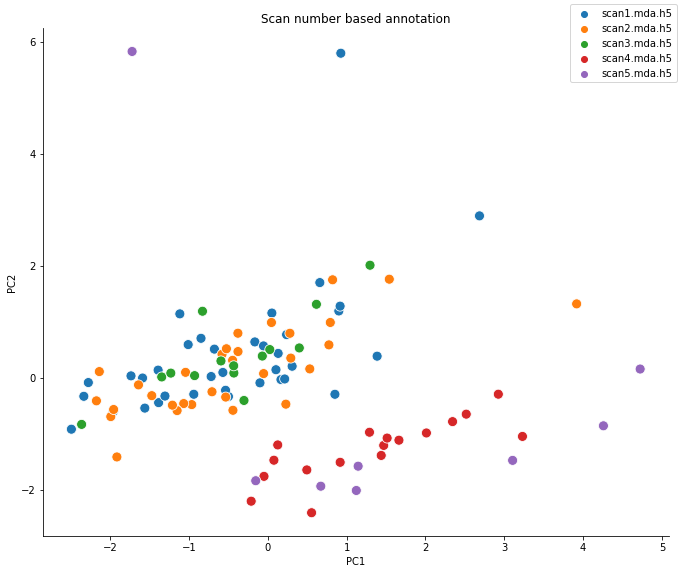

In [15]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='scan_name', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Scan number based annotation')
plt.tight_layout()

plt.savefig('../figures/pc_space_scan_tagged.jpg')

In [16]:
print(secondaryDf[['area','eccentricity', 'K','P','Ca','Zn','Fe']].to_latex(index=True))  

\begin{tabular}{lrrrrrrr}
\toprule
{} &    area &  eccentricity &         K &         P &        Ca &        Zn &        Fe \\
\midrule
0   &  1.9375 &      0.926864 &  0.000042 &  0.000085 &  0.000074 &  0.000071 &  0.000048 \\
1   &  1.3125 &      0.945323 &  0.000069 &  0.000055 &  0.000065 &  0.000051 &  0.000035 \\
2   &  0.6875 &      0.755929 &  0.000046 &  0.000057 &  0.000034 &  0.000053 &  0.000040 \\
3   &  2.6250 &      0.926738 &  0.000054 &  0.000088 &  0.000078 &  0.000055 &  0.000042 \\
4   &  1.1250 &      0.722659 &  0.000042 &  0.000064 &  0.000100 &  0.000070 &  0.000044 \\
5   &  3.0625 &      0.925859 &  0.000044 &  0.000089 &  0.000127 &  0.000077 &  0.000041 \\
6   &  5.9375 &      0.993093 &  0.000055 &  0.000079 &  0.000064 &  0.000049 &  0.000051 \\
7   &  2.3750 &      0.927087 &  0.000055 &  0.000073 &  0.000113 &  0.000045 &  0.000046 \\
8   &  2.9375 &      0.984730 &  0.000050 &  0.000099 &  0.000051 &  0.000058 &  0.000039 \\
9   &  3.1250 &      0.9777

/tmp/ipykernel_33714/2506169708.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(secondaryDf[['area','eccentricity', 'K','P','Ca','Zn','Fe']].to_latex(index=True))


# perform k-means

/tmp/ipykernel_33714/2630405428.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['Class'] = kmeans.labels_


inertia:  250.1344317388474


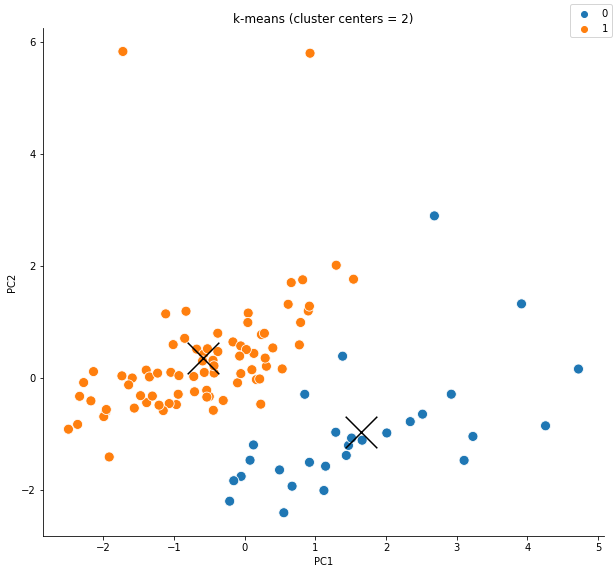

In [17]:


kmeans = KMeans(init="k-means++",n_clusters = 2, n_init=200, random_state = 42).fit(secondaryDf[['PC1','PC2']].to_numpy())
inertia=kmeans.inertia_
secondaryDf['Class'] = kmeans.labels_

print('inertia: ', inertia)
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='k-means (cluster centers = 2)')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')
plt.tight_layout()
plt.savefig('../figures/pc_space_km_clustered.jpg')



# guide user to understand what kmeans.class means?

In [18]:
print('k-means assigned class to max K cell:', secondaryDf.iloc[secondaryDf['K'].idxmax()]['Class'])
print('High K cell should be 1. Is it?', secondaryDf.iloc[secondaryDf['K'].idxmax()]['Class'] ==1 )

k-means assigned class to max K cell: 1
High K cell should be 1. Is it? True


# apply scan based filter to annotate ideal cluster



Length true list:  81
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dict_keys(['False', 'True'])


/tmp/ipykernel_33714/2911525628.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['text_labels'] = text_labels


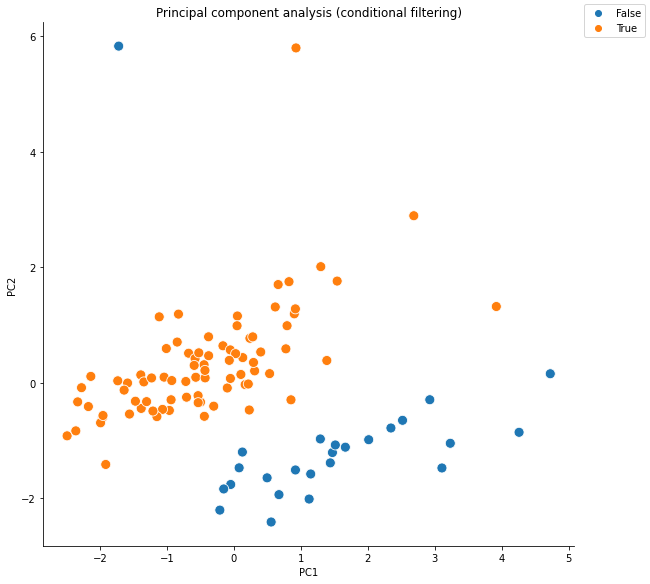

In [20]:
# condition check

labels = [0] * mod_X.shape[0]
text_labels=labels
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='scan1.mda.h5') | 
    (secondaryDf['scan_name']=='scan2.mda.h5') | 
    (secondaryDf['scan_name']=='scan3.mda.h5')  
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
print(labels)


y_dh=np.array(labels).astype(int)    #domain h labels
y=labels

RANGE=mod_X.shape[0]

for idx in range(RANGE):
    if text_labels[idx] ==0:
        text_labels[idx] = False
    if text_labels[idx] ==1:
        text_labels[idx] = True
        
secondaryDf['text_labels'] = text_labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (conditional filtering)')



# count cells from each XRF

In [40]:
secondaryDf[secondaryDf['scan_name']=='scan5.mda.h5'].count()

Pixel_count            8
area                   8
eccentricity           8
equivalent_diameter    8
major_axis_length      8
minor_axis_length      8
perimeter              8
K                      8
P                      8
Ca                     8
Zn                     8
Fe                     8
Cu                     8
BFY                    8
x_res                  8
y_res                  8
avg_res                8
x_origin               8
y_origin               8
x_motor                8
y_motor                8
xrf_file               8
scan_name              8
original index         8
PC1                    8
PC2                    8
text_labels            8
dwell_times            8
inv_dwell_times        8
Class                  8
p0                     8
p1                     8
p2                     8
confidence             8
y                      8
labels                 8
dtype: int64

# fuzzy k-means (currently works for 2 PCs)

In [22]:
df=secondaryDf

In [23]:
df

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ca,...,y_motor,xrf_file,scan_name,original index,PC1,PC2,text_labels,dwell_times,inv_dwell_times,Class
0,31,1.9375,0.926864,1.570637,2.566840,0.963588,5.242641,0.000042,0.000085,0.000074,...,-654.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5,1,0.166639,-0.033176,True,100.0,0.01,1
1,21,1.3125,0.945323,1.292721,2.313760,0.754599,3.828427,0.000069,0.000055,0.000065,...,-652.315186,../xrfdata/scan1.mda.h5,scan1.mda.h5,3,-1.116131,1.140094,True,100.0,0.01,1
2,11,0.6875,0.755929,0.935603,1.128152,0.738549,2.414214,0.000046,0.000057,0.000034,...,-650.565186,../xrfdata/scan1.mda.h5,scan1.mda.h5,4,-2.334037,-0.332396,True,100.0,0.01,1
3,42,2.6250,0.926738,1.828183,3.026790,1.137187,6.389087,0.000054,0.000088,0.000078,...,-648.065186,../xrfdata/scan1.mda.h5,scan1.mda.h5,5,0.131042,0.433937,True,100.0,0.01,1
4,18,1.1250,0.722659,1.196827,1.423347,0.983824,3.267767,0.000042,0.000064,0.000100,...,-648.065186,../xrfdata/scan1.mda.h5,scan1.mda.h5,6,-0.939156,-0.295826,True,100.0,0.01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,31,1.9375,0.930962,1.570637,2.610152,0.953011,5.535534,0.000022,0.000129,0.000147,...,-1046.726318,../xrfdata/scan5.mda.h5,scan5.mda.h5,116,4.257249,-0.859209,False,100.0,0.01,0
102,20,1.2500,0.886135,1.261566,1.858871,0.861452,3.974874,0.000013,0.000118,0.000083,...,-1043.726318,../xrfdata/scan5.mda.h5,scan5.mda.h5,117,1.122454,-2.014436,False,100.0,0.01,0
103,20,1.2500,0.948433,1.261566,2.289306,0.725656,4.078427,0.000017,0.000107,0.000079,...,-1041.976318,../xrfdata/scan5.mda.h5,scan5.mda.h5,118,1.145811,-1.580795,False,100.0,0.01,0
104,21,1.3125,0.941908,1.292721,2.248000,0.755036,4.181981,0.000017,0.000119,0.000056,...,-1034.226318,../xrfdata/scan5.mda.h5,scan5.mda.h5,122,0.671847,-1.938220,False,100.0,0.01,0


In [24]:
#for 2 PCs
for i in range(3):
    df['p' + str(i)] = 0
    
# df[['p0', 'p1']] = soft_clustering_weights(X, kmeans.cluster_centers_)
df[['p0', 'p1']] = soft_clustering_weights(principalComponents, kmeans.cluster_centers_)
df['confidence'] = np.max(df[['p0', 'p1']].values, axis = 1)

/tmp/ipykernel_33714/994511390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p' + str(i)] = 0
/tmp/ipykernel_33714/994511390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['p' + str(i)] = 0
/tmp/ipykernel_33714/994511390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [25]:
df['confidence']

0      0.947668
1      0.994363
2      0.955474
3      0.984775
4      0.994402
         ...   
101    0.930067
102    0.974564
103    0.991366
104    0.928316
105    0.607374
Name: confidence, Length: 106, dtype: float64

In [26]:
np.unique(df['Class'].to_numpy())

array([0, 1], dtype=int32)

In [27]:
labels = [0] * mod_X.shape[0]
text_labels=labels
True_list = secondaryDf.loc[
    (secondaryDf['scan_name']=='scan1.mda.h5') | 
    (secondaryDf['scan_name']=='scan2.mda.h5') | 
    (secondaryDf['scan_name']=='scan3.mda.h5')  
   ].index.tolist()       
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
print(labels)
y_dh=np.array(labels).astype(int)

df['y']=y_dh
df['labels']=y_dh

Length true list:  81
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/tmp/ipykernel_33714/2232615966.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y']=y_dh
/tmp/ipykernel_33714/2232615966.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels']=y_dh


In [28]:
df['labels']

0      1
1      1
2      1
3      1
4      1
      ..
101    0
102    0
103    0
104    0
105    0
Name: labels, Length: 106, dtype: int64

In [29]:
# Make sure colours are the same for the actual class and the kmeans class in the plots.
# Count the most frequent species that appears in each class
df_color_converter = df.groupby('Class', as_index = False)['labels'].mean().round().astype(int)
color_converter_dict = {}
for ind in df_color_converter.index:
    color_converter_dict[ind] = df_color_converter.loc[ind, 'labels']
    
    

In [30]:
len(y_dh)

106

In [31]:
y_dh

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


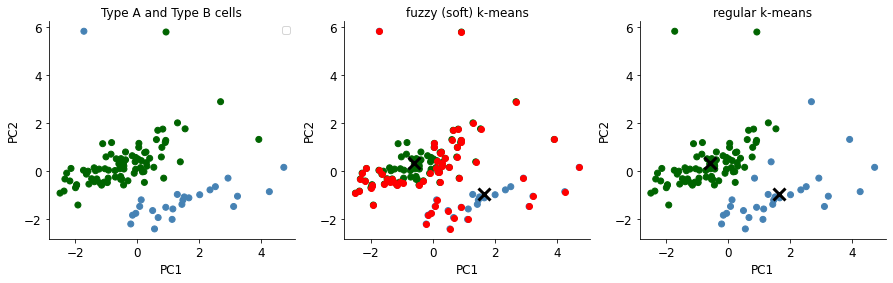

In [32]:
colors = [ 'steelblue', 'darkgreen']

fig, axs = plt.subplots(1, 3, figsize = (15,4))

ax = _format_soft_km_axes(axs[0])

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in y_dh]
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Type A and Type B cells', pad = 5, fontsize = 12)
ax.legend()
plt.savefig('../figures/FCKM_ideal_labels.jpg')

# ax.set_ylim(-0.2, 2.7)
# ax.set_xlim(0.7, 7.3)

# ax.plot(
#     kmeans.cluster_centers_[:,-2],
#     kmeans.cluster_centers_[:,-1],
#     'xk',
#     markersize = 15,
#     markeredgewidth = 3
# )

ax = _format_soft_km_axes(axs[1])

confidence_threshold=0.99 #0.9 default

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in y_dh]
)

ax.scatter(
    df.loc[df['confidence'] < confidence_threshold, 'PC1'],
    df.loc[df['confidence'] < confidence_threshold, 'PC2'],
#     color = df.loc[df['confidence'] > confidence_threshold, 'Class'].apply(lambda x: colors[color_converter_dict[x]])
    color = ['red']
)

ax.plot(
    kmeans.cluster_centers_[:,-2],
    kmeans.cluster_centers_[:,-1],
    'xk',
    markersize = 12,
    markeredgewidth = 3
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('fuzzy (soft) k-means', pad = 5, fontsize = 12)




ax = _format_soft_km_axes(axs[2])

ax.scatter(
    df[['PC1']].to_numpy(),
    df[['PC2']].to_numpy(),
    color = [colors[i] for i in kmeans.labels_]
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('regular k-means', pad = 5, fontsize = 12)


# ax.set_ylim(-0.2, 2.7)
# ax.set_xlim(0.7, 7.3)

ax.plot(
    kmeans.cluster_centers_[:,-2],
    kmeans.cluster_centers_[:,-1],
    'xk',
    markersize = 12,
    markeredgewidth = 3
)

plt.savefig('../figures/FCKM.jpg')


# apply a simple condition to filter the data

Length true list:  21
dict_keys(['False', 'True'])


/tmp/ipykernel_33714/2200894824.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['text_labels'] = labels


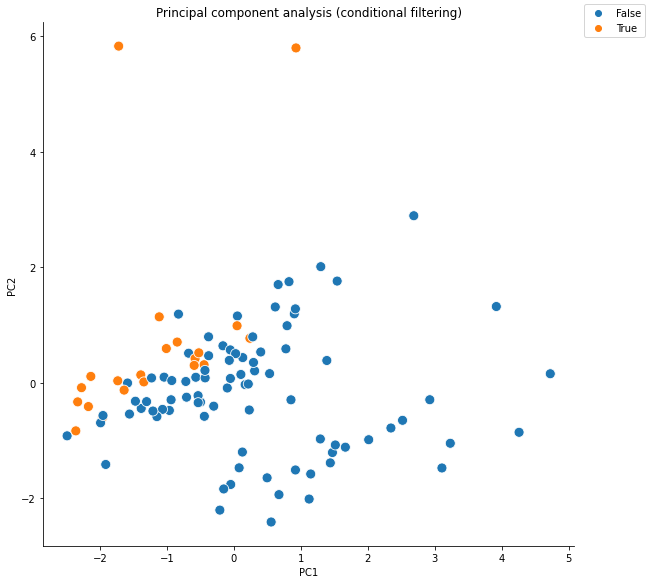

In [33]:
# condition check

labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[
    (secondaryDf['major_axis_length']>=1) & 
    (secondaryDf['major_axis_length']<= 3) &
    (secondaryDf['minor_axis_length']>=0.5) & 
    (secondaryDf['minor_axis_length']<= 1.5) &
    (secondaryDf['K']>=secondaryDf['K'].median()) &
    (secondaryDf['K']/secondaryDf['P']>=(secondaryDf['K']/secondaryDf['P']).median())
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 

y_dh=labels    #domain h labels
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = False
    if labels[idx] ==1:
        labels[idx] = True
        
secondaryDf['text_labels'] = labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (conditional filtering)')



In [34]:
# # look for outliers if exist
# secondaryDf[secondaryDf['PC2']>8]

In [35]:
# # check if the filtering true false labels are correct

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     display(secondaryDf)

# secondaryDf['original index']

# view distribution of features for the two kmeans classes

Text(0.5, 1.0, 'k-means (class = 1)')

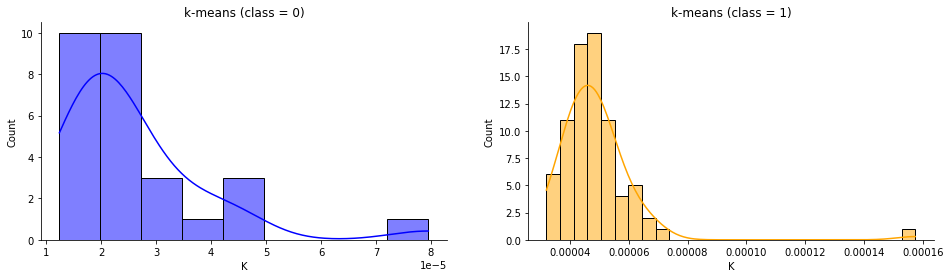

In [36]:
select_feature_channel = 'K'

secondaryDf[secondaryDf['Class']==0][select_feature_channel]
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(ax=ax[0],data=secondaryDf[secondaryDf['Class']==0], x=select_feature_channel, kde=True,color='blue')
ax[0].set_title('k-means (class = 0)')

sns.histplot(ax=ax[1],data=secondaryDf[secondaryDf['Class']==1], x=select_feature_channel, kde=True,color='orange')
ax[1].set_title('k-means (class = 1)')

# view the last xrf files extracted cells on the PC plot marked with orange

Length true list:  8


/tmp/ipykernel_33714/3761272709.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondaryDf['text_labels'] = labels


<IPython.core.display.Javascript object>


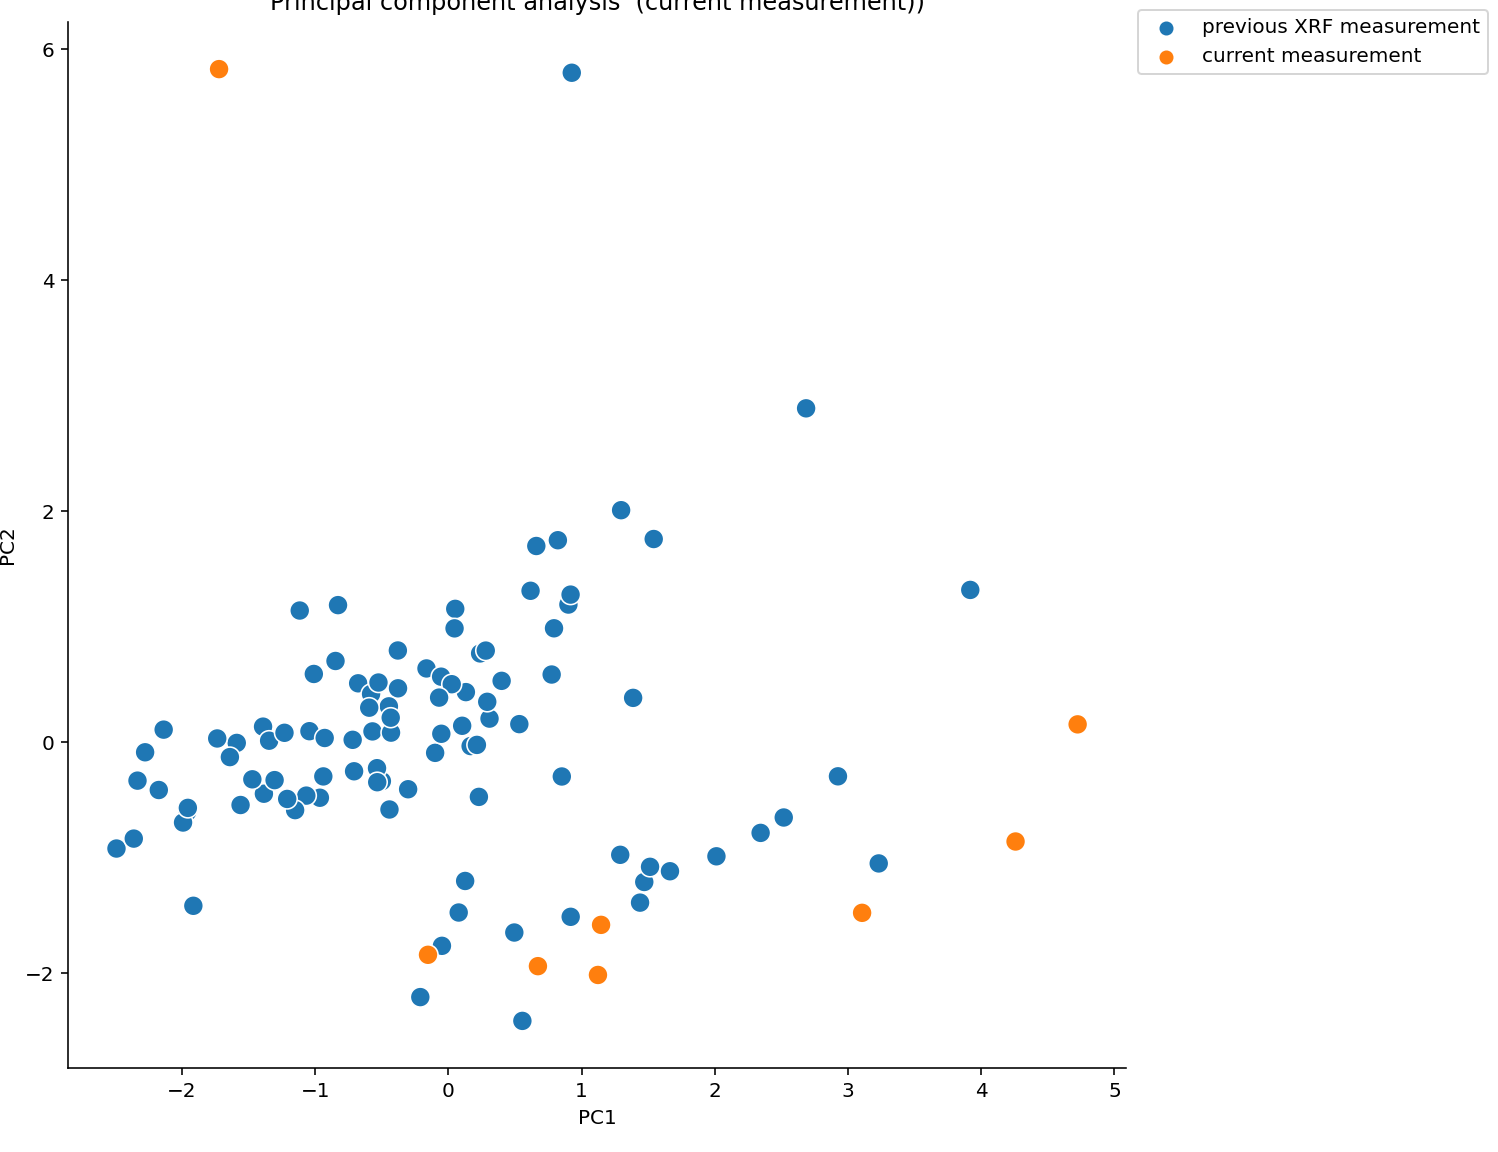

dict_keys(['previous XRF measurement', 'current measurement'])


In [47]:
# condition check


labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[(secondaryDf['xrf_file']==secondaryDf['xrf_file'].to_numpy()[-1])].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
    
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'previous XRF measurement'
    if labels[idx] ==1:
        labels[idx] = 'current measurement'
        
secondaryDf['text_labels'] = labels

pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis  (current measurement))')

